In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np

from net2 import Generator2, Discriminator2
from net import Generator, Discriminator
from data.mpii import MPIIDataset
from utils.vis import draw_keypoints

import matplotlib.pyplot as plt

In [11]:
checkpoint = torch.load('out/out_02.06.2021_14:22/799_model.pt')

In [12]:
gen = Generator().to('cuda')
gen.load_state_dict(checkpoint['g_state_dict'])

<All keys matched successfully>

In [13]:
dataset = MPIIDataset('../data/mpii2cats.json')

=> num db: 1874
=> num selected db: 1874
=> load 1874 samples


In [14]:
dataset.cat_names

['standing', 'sitting']

In [15]:
category = dataset.cat_names[:2]

In [16]:
label = dataset.one_hot[:2]
label = Variable(label.type(torch.cuda.LongTensor))

In [17]:
noise = Variable(torch.cuda.FloatTensor(np.random.normal(0, 1, (2, 64))), requires_grad=False)

In [18]:
out = gen(noise, label).cpu().detach().numpy()

standing


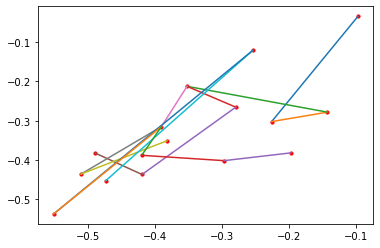

sitting


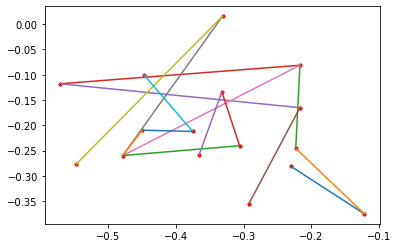

In [19]:
i = 0
for j in out:
    print(category[i])
    i += 1
    draw_keypoints(j)

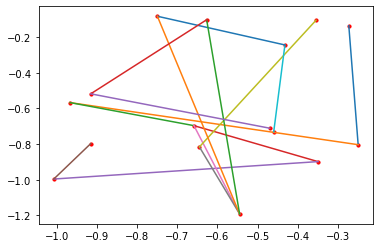

In [156]:
draw_keypoints([[0.2727, 0.1359],
        [0.2494, 0.8034],
        [0.9671, 0.5673],
        [0.3495, 0.8983],
        [1.0078, 0.9960],
        [0.9156, 0.7970],
        [0.6585, 0.6966],
        [0.5448, 1.1917],
        [0.6450, 0.8158],
        [0.3544, 0.1053],
        [0.4598, 0.7309],
        [0.4319, 0.2439],
        [0.7497, 0.0828],
        [0.6269, 0.1024],
        [0.9157, 0.5180],
        [0.4697, 0.7109]])

In [129]:
max_ = 0

for i in range(len(dataset)):
    m = max(np.concatenate(dataset[i][0].numpy()))
    if (m > max_):
        max_ = m

In [130]:
max_

1.1093547

In [138]:
kp = dataset[2][0]

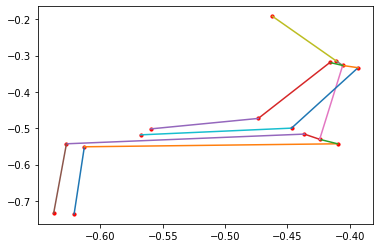

In [139]:
draw_keypoints(kp)

In [40]:
def make_coordinate_grid(spatial_size, type):
    h, w = spatial_size
    x = torch.arange(w).type(type)
    y = torch.arange(h).type(type)
    x = x / (w - 1)
    y = y / (h - 1)
    yy = y.view(-1, 1).repeat(1, w)
    xx = x.view(1, -1).repeat(h, 1)
    meshed = torch.cat([xx.unsqueeze_(2), yy.unsqueeze_(2)], 2)
    return meshed

def kp2gaussian(kp, spatial_size, kp_variance):
    coordinate_grid = make_coordinate_grid(spatial_size, kp.type())
    number_of_leading_dimensions = len(kp.shape) - 1
    shape = (1,) * number_of_leading_dimensions + coordinate_grid.shape
    coordinate_grid = coordinate_grid.view(*shape)
    repeats = kp.shape[:number_of_leading_dimensions] + (1, 1, 1)
    coordinate_grid = coordinate_grid.repeat(*repeats)
    shape = kp.shape[:number_of_leading_dimensions] + (1, 1, 2)
    kp = kp.view(*shape)
    mean_sub = (coordinate_grid - kp)
    out = torch.exp(-0.5 * (mean_sub ** 2).sum(-1) / kp_variance)
    return out

In [145]:
gs = kp2gaussian(kp, (64, 64), 5e-4)
gs.size()

torch.Size([16, 64, 64])

In [146]:
sum_gs = torch.sum(gs, dim=0)

In [147]:
sum_gs

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

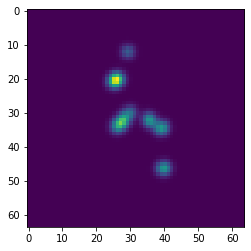

In [148]:
plt.imshow(sum_gs)